#  Analyse spectra ADR holo at AuxTel for Configuration PSF1D REBIN = 1, Search for clustering

- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNES, DESC-LSST fullmember, behalf AuxTel Teal VERA C. Rubin observatory
- 
- creation date : September 12th  2022
- last update : September 12th 2022

- **kernel anaconda3_auxtel** at CC or **python 3** locally


## Search for cluster Order 1 and order 2

# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
import pandas as pd

import matplotlib.ticker                         # here's where the formatter is
import os
import re
import pandas as pd

plt.rcParams["figure.figsize"] = (16,4)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'

In [109]:
plt.rcParams["axes.labelsize"]="large"
plt.rcParams["axes.linewidth"]=2.0
plt.rcParams["xtick.major.size"]=8
plt.rcParams["ytick.major.size"]=8
plt.rcParams["ytick.minor.size"]=5
plt.rcParams["xtick.labelsize"]="large"
plt.rcParams["ytick.labelsize"]="large"

plt.rcParams["figure.figsize"]=(12,8)
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.titleweight'] = 'bold'
#plt.rcParams['axes.facecolor'] = 'blue'
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'
plt.rcParams['lines.markeredgewidth'] = 0.3 # the line width around the marker symbol
plt.rcParams['lines.markersize'] = 5  # markersize, in points
plt.rcParams['grid.alpha'] = 0.75 # transparency, between 0.0 and 1.0
plt.rcParams['grid.linestyle'] = '-' # simple line
plt.rcParams['grid.linewidth'] = 0.4 # in points
plt.rcParams['font.size'] = 13


In [2]:
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle

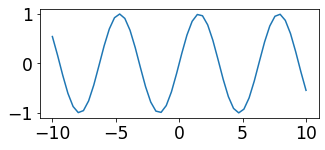

In [3]:
fig=plt.figure(figsize=(5,2))
ax=fig.add_subplot(1,1,1)
X=np.linspace(-10,10,50)
Y=np.sin(X)
ax.plot(X,Y)
plt.show()               

In [4]:
import matplotlib.offsetbox
props = dict(boxstyle='round',edgecolor="w",facecolor="w", alpha=0.5)

In [5]:
from datetime import datetime,date

In [6]:
#pip install fpdf
#from fpdf import FPDF

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

In [7]:
today = date.today()
string_date=today.strftime("%Y-%m-%d")

In [8]:
string_date

'2022-09-12'

In [9]:
from iminuit import Minuit
import iminuit

In [10]:
iminuit.__version__

'2.8.4'

In [11]:
from astropy.io import fits
from spectractor import parameters
from spectractor.extractor.extractor import Spectractor, dumpParameters, FullForwardModelFitWorkspace,  run_ffm_minimisation, plot_comparison_truth,dumpfitparameters
from spectractor.extractor.spectrum import Spectrum, detect_lines
from spectractor.extractor.spectrum import *
#from spectractor.extractor.spectroscopy import Lines, Line ,HALPHA, HBETA, O2_1, H2O_1,H2O_2
from spectractor.extractor.spectroscopy import Lines, Line ,HALPHA, HBETA, O2_1, H2O_1, ATMOSPHERIC_LINES
from spectractor.config import load_config,set_logger
from spectractor import parameters
from spectractor.extractor.images import *
from scipy import ndimage, misc
from scipy.interpolate import interp1d

In [12]:
import logging

In [13]:
H2O_2 = Line(960, atmospheric=True, label=r'$H_2 O$', label_pos=[0.007, 0.02],width_bounds=[5, 30])  # libradtran paper fig.3, broad line

In [14]:
from time import sleep

In [15]:
from astropy.time import Time
import astropy.units as u

In [16]:
import pickle

# Function

In [17]:
def file_tag_forsorting(filename):
    # m=re.findall('^Cor_holo4_003_.*([0-9][0-9][0-9][0-9]-[0-9][0-9]-[0-9][0-9]_.*)[.]fits$',filename)
    m = re.findall('^exposure_.*([0-9][0-9][0-9][0-9][0-9])_postisrccd.*', filename)
    if len(m)>0:
        return m[0]
    else:
        return None


In [18]:
def subdir_tag_forsorting(subdir):
    # m=re.findall('^Cor_holo4_003_.*([0-9][0-9][0-9][0-9]-[0-9][0-9]-[0-9][0-9]_.*)[.]fits$',filename)
    m = re.findall('.*([0-9][0-9][0-9][0-9][0-9])$', subdir)
    if len(m)>0:
        return m[0]
    else:
        return None


In [19]:
file_tag_forsorting('exposure_2022031600330_postisrccd.fits')

'00330'

In [20]:
subdir_tag_forsorting('2022031600330')

'00330'

# Config

In [21]:
my_logger = logging

In [22]:
# path index for each month
DATE="20220316"
#DATE="20211104"
filterdispersername = "empty~holo4_003"
#filterdispersername = "BG40~holo4_003"
imagemode = "postISRCCD"
#imagemode = "unflattened"

In [23]:
version="v5.0"

In [24]:
# Choose the config filename
list_of_spectractorconfigfiles= ['auxtel_config_holo_DECONVOLUTION_PSF1D.ini' ,
                                 'auxtel_config_holo_DECONVOLUTION_PSF2D.ini',
                                 'auxtel_config_holo_DECONVOLUTION_FFM.ini',
                                 'auxtel_config_holo_DECONVOLUTION_PSF2DFFM.ini',
                                 'auxtel_config_holo_DECONVOLUTION_REBIN2PSF1D.ini',
                                 'auxtel_config_holo_DECONVOLUTION_REBIN2FFM.ini',
                                 'auxtel_config_holo_DECONVOLUTION_REBIN2PSF1DFFM300650.ini',
                                 'auxtel_config_holo_DECONVOLUTION_REBIN2PSF2D.ini',
                                 'auxtel_config_holo_DECONVOLUTION_REBIN2PSF1DrotA.ini',
                                 'auxtel_config_holo_DECONVOLUTION_REBIN2PSF1DrotB.ini',
                                 'auxtel_config_holo_DECONVOLUTION_REBIN2PSF1DrotC.ini',
                                 'auxtel_config_holo_DECONVOLUTION_REBIN2PSF1DrotD.ini']
config_idx = 0    

configfilename= os.path.join("./config",list_of_spectractorconfigfiles[config_idx])
#configdir = (list_of_spectractorconfigfiles[config_idx].split("_")[-1]).split(".") [0]
configdir = "config_" + (list_of_spectractorconfigfiles[config_idx].split("auxtel_config_holo_")[-1]).split(".") [0]

In [25]:
configdir 

'config_DECONVOLUTION_PSF1D'

In [26]:
load_config(configfilename)

No rebinning: parameters.REBIN is forced to 1.


In [27]:
#parameters.LAMBDA_MAX=700
#parameters.LAMBDA_MIN=300

In [28]:
dumpParameters()

ASTROMETRYNET_DIR 
BGD_ORDER 1
CALIB_BGD_NPARAMS 4
CALIB_BGD_ORDER 3
CALIB_BGD_WIDTH 15
CALIB_PEAK_WIDTH 7
CALIB_SAVGOL_ORDER 2
CALIB_SAVGOL_WINDOW 5
CCD_ARCSEC2RADIANS 4.84813681109536e-06
CCD_GAIN 1.1
CCD_IMSIZE 4096
CCD_MAXADU 170000
CCD_PIXEL2ARCSEC 0.0952
CCD_PIXEL2MM 0.01
CCD_REBIN 1
CONFIG_DIR /sps/lsst/groups/auxtel/softs/utils/anaconda3/lib/python3.8/site-packages/Spectractor-2.1-py3.8.egg/spectractor/../config/
DEBUG False
DEBUG_LOGGING False
DISPERSER_DIR /sps/lsst/groups/auxtel/softs/utils/anaconda3/lib/python3.8/site-packages/Spectractor-2.1-py3.8.egg/spectractor/extractor/dispersers/
DISPLAY False
DISTANCE2CCD 175
DISTANCE2CCD_ERR 0.75
FGB37 {'label': 'FGB37', 'min': 350, 'max': 750}
FILTERS [{'label': 'RG715', 'min': 690, 'max': 1100}, {'label': 'FGB37', 'min': 350, 'max': 750}, {'label': 'Halfa', 'min': 0.0006431, 'max': 0.0006686999999999999}, {'label': 'Z-Gunn', 'min': 800, 'max': 1100}]
FLAM_TO_ADURATE 5175865186660.421
GRATING_ORDER_2OVER1 0.1
GROOVES_PER_MM 350
HAL

In [29]:
configmode = list_of_spectractorconfigfiles[config_idx].split("auxtel_config_holo_DECONVOLUTION_")[-1].split(".") [0]
configmode

'PSF1D'

# Path

In [30]:
HOSTCC=True
LAPTOP=False

In [31]:
# Set path depending on which computer running (according HOSTCC)
if HOSTCC:
    path_auxtel="/sps/lsst/groups/auxtel"
    path_spectractor=os.path.join(path_auxtel,"softs/github/desc/Spectractor")
    path_spectractor_config=os.path.join(path_spectractor,"config")
    path_images=os.path.join(path_auxtel,"data/2022/"+filterdispersername+"/"+DATE)
    if configdir == "":
        path_output_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+DATE)
    else:
        path_output_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+configdir+"/"+DATE)
        path_topoutput_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+configdir)
        path_toptopoutput_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername)
        path_toptoptopoutput_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode)

else:
    if not LAPTOP:
        path_auxtel="/Users/sylvie/DATA/AuxTelData2022"
        path_spectractor=os.path.join(path_auxtel,"/Users/sylvie/MacOSX/GitHub/LSST/Spectractor")
        path_spectractor_config=os.path.join(path_spectractor,"config")
        path_images=os.path.join(path_auxtel,"data/2022/"+filterdispersername+"/"+DATE)
        if configdir == "":
            path_output_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+DATE)
        else:
            path_output_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+configdir+"/"+DATE)
            path_topoutput_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+configdir)
            path_toptopoutput_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername)
            path_toptoptopoutput_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode)
    else:
        path_auxtel="/Users/dagoret/DATA/AuxTelData2022"
        path_spectractor=os.path.join(path_auxtel,"/Users/dagoret/MacOSX/GitHub/LSST/Spectractor")
        path_spectractor_config=os.path.join(path_spectractor,"config")
        path_images=os.path.join(path_auxtel,"data/2022/"+filterdispersername+"/"+DATE)
        if configdir == "":
            path_output_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+DATE)
        else:
            path_output_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+configdir+"/"+DATE)
            path_topoutput_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+configdir)
            path_toptopoutput_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername)
            path_toptoptopoutput_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode)
                

In [32]:
path_output_spectractor

'/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF1D/20220316'

In [33]:
! ls -l $path_output_spectractor

total 0
drwxrws--- 1 dagoret lsst 2 May 30 22:16 2022031600330
drwxrws--- 1 dagoret lsst 2 May 31 06:45 2022031600331
drwxrws--- 1 dagoret lsst 2 May 31 06:44 2022031600337
drwxrws--- 1 dagoret lsst 2 May 31 06:43 2022031600338
drwxrws--- 1 dagoret lsst 2 May 31 06:44 2022031600344
drwxrws--- 1 dagoret lsst 2 May 31 06:44 2022031600345
drwxrws--- 1 dagoret lsst 2 May 31 06:46 2022031600351
drwxrws--- 1 dagoret lsst 2 May 31 06:47 2022031600352
drwxrws--- 1 dagoret lsst 2 May 31 06:46 2022031600358
drwxrws--- 1 dagoret lsst 2 May 31 06:46 2022031600359
drwxrws--- 1 dagoret lsst 2 May 31 06:46 2022031600365
drwxrws--- 1 dagoret lsst 2 May 31 06:45 2022031600366
drwxrws--- 1 dagoret lsst 2 May 31 06:45 2022031600372
drwxrws--- 1 dagoret lsst 2 May 31 06:45 2022031600373
drwxrws--- 1 dagoret lsst 2 May 31 06:45 2022031600379
drwxrws--- 1 dagoret lsst 2 May 31 06:45 2022031600380
drwxrws--- 1 dagoret lsst 2 May 31 06:45 2022031600386
drwxrws--- 1 dagoret lsst 2 May 31 06:46 2022031600387
dr

In [34]:
# standard configuration for spectractor
#config = os.path.join(path_spectractor_config,"auxtel.ini")
#config=os.path.join("./config",configfilename)
config=configfilename
print(f">>>>> Spectractor configuration filename : {configfilename}")

>>>>> Spectractor configuration filename : ./config/auxtel_config_holo_DECONVOLUTION_PSF1D.ini


In [35]:
load_config(configfilename)

No rebinning: parameters.REBIN is forced to 1.


## Logbook for file selection

In [36]:
filename_logbook='logbooks/auxtellogbook_'+filterdispersername+"_"+DATE+'_' + version+'.csv'

In [37]:
df=pd.read_csv(filename_logbook,index_col=0)

In [38]:
pd.set_option('display.max_rows', None)

In [39]:
df

,index,date,path,file,num,object,filter,disperser,airmass,exposure,...,temperature,humidity,windspd,Obj-posXpix,Obj-posYpix,Dx,Dy,skip,run,quality
0,0,2022-03-17T01:59:37.776,/sps/lsst/groups/auxtel/data/2022/empty~holo4_...,exposure_2022031600330_postisrccd.fits,330,eta dor,empty_1,holo4_003,1.385409,20.0,...,10.6,44.0,7.2,NaN,NaN,NaN,NaN,,NaN,NaN
1,1,2022-03-17T02:00:10.693,/sps/lsst/groups/auxtel/data/2022/empty~holo4_...,exposure_2022031600331_postisrccd.fits,331,eta dor,empty_1,holo4_003,1.386483,20.0,...,10.6,44.0,7.4,NaN,NaN,NaN,NaN,,NaN,NaN
2,2,2022-03-17T02:03:04.275,/sps/lsst/groups/auxtel/data/2022/empty~holo4_...,exposure_2022031600337_postisrccd.fits,337,eta dor,empty_1,holo4_003,1.392269,20.0,...,10.6,43.0,7.4,NaN,NaN,NaN,NaN,,NaN,NaN
3,3,2022-03-17T02:03:37.365,/sps/lsst/groups/auxtel/data/2022/empty~holo4_...,exposure_2022031600338_postisrccd.fits,338,eta dor,empty_1,holo4_003,1.393378,20.0,...,10.6,43.0,7.4,NaN,NaN,NaN,NaN,,NaN,NaN
4,4,2022-03-17T02:06:31.026,/sps/lsst/groups/auxtel/data/2022/empty~holo4_...,exposure_2022031600344_postisrccd.fits,344,eta dor,empty_1,holo4_003,1.399309,20.0,...,10.5,43.0,8.2,NaN,NaN,NaN,NaN,,NaN,NaN
5,5,2022-03-17T02:07:03.927,/sps/lsst/groups/auxtel/data/2022/empty~holo4_...,exposure_2022031600345_postisrccd.fits,345,eta dor,empty_1,holo4_003,1.400449,20.0,...,10.5,43.0,7.6,NaN,NaN,NaN,NaN,,NaN,NaN
6,6,2022-03-17T02:11:00.681,/sps/lsst/groups/auxtel/data/2022/empty~holo4_...,exposure_2022031600351_postisrccd.fits,351,HD111980,empty_1,holo4_003,1.647734,20.0,...,10.5,43.0,13.1,300.0,1700.0,NaN,NaN,,1.0,1.0
7,7,2022-03-17T02:11:33.581,/sps/lsst/groups/auxtel/data/2022/empty~holo4_...,exposure_2022031600352_postisrccd.fits,352,HD111980,empty_1,holo4_003,1.643280,20.0,...,10.5,43.0,13.1,NaN,NaN,NaN,NaN,,NaN,NaN
8,8,2022-03-17T02:14:30.261,/sps/lsst/groups/auxtel/data/2022/empty~holo4_...,exposure_2022031600358_postisrccd.fits,358,HD111980,empty_1,holo4_003,1.619945,20.0,...,10.5,43.0,12.1,NaN,NaN,NaN,NaN,,NaN,NaN
9,9,2022-03-17T02:15:03.181,/sps/lsst/groups/auxtel/data/2022/empty~holo4_...,exposure_2022031600359_postisrccd.fits,359,HD111980,empty_1,holo4_003,1.615702,20.0,...,10.5,44.0,6.9,NaN,NaN,NaN,NaN,,NaN,NaN


## Selection of input files

In [40]:
# Do not consider flag
#df_good=df[df["quality"]==1]

In [41]:
df_good=df
df_good["quality"] = 1

In [42]:
for spectra_file in df_good["file"]:
    print(spectra_file)

exposure_2022031600330_postisrccd.fits
exposure_2022031600331_postisrccd.fits
exposure_2022031600337_postisrccd.fits
exposure_2022031600338_postisrccd.fits
exposure_2022031600344_postisrccd.fits
exposure_2022031600345_postisrccd.fits
exposure_2022031600351_postisrccd.fits
exposure_2022031600352_postisrccd.fits
exposure_2022031600358_postisrccd.fits
exposure_2022031600359_postisrccd.fits
exposure_2022031600365_postisrccd.fits
exposure_2022031600366_postisrccd.fits
exposure_2022031600372_postisrccd.fits
exposure_2022031600373_postisrccd.fits
exposure_2022031600379_postisrccd.fits
exposure_2022031600380_postisrccd.fits
exposure_2022031600386_postisrccd.fits
exposure_2022031600387_postisrccd.fits
exposure_2022031600393_postisrccd.fits
exposure_2022031600394_postisrccd.fits
exposure_2022031600400_postisrccd.fits
exposure_2022031600401_postisrccd.fits
exposure_2022031600420_postisrccd.fits
exposure_2022031600421_postisrccd.fits
exposure_2022031600427_postisrccd.fits
exposure_2022031600428_po

## Selection of Spectractor output files

In [43]:
# total number of exposures
NBEXP=0
# total number of exposures without dir
NBEXPNODIR=0
# total number of exposures with dir
NBEXPWTHDIR=0
# total number of exposures with plots
NBEXPWTHPLT=0
# total number of exposures with spectra
NBEXPWTHSPEC=0

# list of exposures
LISTNUM=[]
# list of exposure without dir (not run spectraction)
LISTNUMNODIR=[]
# list of exposure with dir (spectraction has been run)
LISTNUMWTHDIR=[]
# list of exposures with plots (Spectractor has run up to some point)
LISTNUMWTHPLOTS=[]
# list of exposures with spectraction output (Spectractor has completed)
LISTNUMWTHSPECTR=[]

# list of selected spectra path
List_of_spectra_path=[]

In [44]:
list_of_files=os.listdir(path_output_spectractor)
list_of_files=sorted(list_of_files)


print("list of subdir found ",list_of_files)

for subdir in list_of_files:
    
    
    #tag = file_tag_forsorting(subdir)
    tag = subdir_tag_forsorting(subdir)
    
        
    print(tag)    
    #if tag is not None and int(tag)<317:
    #    continue
    if tag is None :
        continue
  
    
    
    fulldir=os.path.join(path_output_spectractor,subdir)



    if not os.path.isdir(fulldir):
        
        print("---------------------------------------------")
        print(subdir," \t  ",tag)
        print("{} is not a directory".format(subdir))
        

        NBEXPNODIR+=1


    else:

        
        print("---------------------------------------------")
        print(subdir," \t  ",tag)
        print("{} is a directory".format(subdir))

        tagname=subdir_tag_forsorting(subdir)
        print("tagname= {}".format(tagname))
        #targetname=file_target(subdir)
        #print("targetname= {}".format(targetname))
        



        NBEXP += 1
        LISTNUM.append(tagname)



        dir_plots=os.path.join(fulldir,"plots")
        dir_spectration = os.path.join(fulldir, "basespec")

        flag_empty1 = True
        flag_empty2 = True


        if os.path.isdir(dir_plots):
            if any(os.scandir(dir_plots)):
                print("dir_plots is not empty")
                NBEXPWTHPLT+=1
                LISTNUMWTHPLOTS.append(tagname)
                flag_empty1 = False

            else:
                print("dir_plots is empty")


        if os.path.isdir(dir_spectration):
            if any(os.scandir(dir_spectration)):
                print("dir_spectration is not empty")
                NBEXPWTHSPEC+=1
                LISTNUMWTHSPECTR.append(tagname)
                flag_empty2 = False
                List_of_spectra_path.append(dir_spectration)

            else:
                print("dir_spectration is empty")

        if flag_empty1 and flag_empty2 :
            NBEXPNODIR+=1
            LISTNUMNODIR.append(tagname)
        else:
            NBEXPWTHDIR += 1
            LISTNUMWTHDIR.append(tagname)



print("-----------------------------------------------------------------")


#LISTNUM=sorted(LISTNUM)
#LISTNUMNODIR=sorted(LISTNUMNODIR)
#LISTNUMWTHDIR=sorted(LISTNUMWTHDIR)
#LISTNUMWTHPLOTS=sorted(LISTNUMWTHPLOTS)
#LISTNUMWTHSPECTR=sorted(LISTNUMWTHSPECTR)
List_of_spectra_path=sorted(List_of_spectra_path)

print("Full list of Exposures : .......................{}".format(LISTNUM))
print("Full list of Exposures without output dir: .....{}".format(LISTNUMNODIR))
print("Full list of Exposures with output dir: ....... {}".format(LISTNUMWTHDIR))
print("Full list of Exposures with output plots: ..... {}".format(LISTNUMWTHPLOTS))
print("Full list of Exposures with output spectra: ....{}".format(LISTNUMWTHSPECTR))




print("Total number of exposures : .....................{}".format(NBEXP))
print("Total number of exposures without dir : .........{}".format(NBEXPNODIR))
print("Total number of exposures with dir :.............{}".format(NBEXPWTHDIR))
print("Total number of exposures with plots : ..........{}".format(NBEXPWTHPLT))
print("Total number of exposures with spectra: .........{}".format(NBEXPWTHSPEC))


list of subdir found  ['2022031600330', '2022031600331', '2022031600337', '2022031600338', '2022031600344', '2022031600345', '2022031600351', '2022031600352', '2022031600358', '2022031600359', '2022031600365', '2022031600366', '2022031600372', '2022031600373', '2022031600379', '2022031600380', '2022031600386', '2022031600387', '2022031600393', '2022031600394', '2022031600400', '2022031600401', '2022031600420', '2022031600421', '2022031600427', '2022031600428', '2022031600434', '2022031600435']
00330
---------------------------------------------
2022031600330  	   00330
2022031600330 is a directory
tagname= 00330
dir_plots is not empty
dir_spectration is not empty
00331
---------------------------------------------
2022031600331  	   00331
2022031600331 is a directory
tagname= 00331
dir_plots is empty
dir_spectration is empty
00337
---------------------------------------------
2022031600337  	   00337
2022031600337 is a directory
tagname= 00337
dir_plots is empty
dir_spectration is empt

In [45]:
#dir_spectra="outputs_reprocess"
print(List_of_spectra_path)

['/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF1D/20220316/2022031600330/basespec']


In [46]:
config

'./config/auxtel_config_holo_DECONVOLUTION_PSF1D.ini'

## Extraction of spectra

In [47]:
all_files_spectra = []
all_files_spectrogram = []
all_files_lines = []
all_files_table = []

# loop on topdir
for dir_spectra in List_of_spectra_path:
    for filename in os.listdir(dir_spectra):
        if re.search("_spectrum.fits$",filename):
            the_file_spectrum=os.path.join(dir_spectra,filename)
            all_files_spectra.append(the_file_spectrum)
            the_file_spectrogram=the_file_spectrum.replace("_spectrum","_spectrogram")
            all_files_spectrogram.append(the_file_spectrogram)
            the_file_lines=the_file_spectrum.replace("_spectrum.fits","_lines.csv")
            all_files_lines.append(the_file_lines)
            the_file_table=the_file_spectrum.replace("_spectrum.fits","_table.csv")
            all_files_table.append(the_file_table)
    

In [48]:
all_files_spectra[:3]

['/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF1D/20220316/2022031600330/basespec/exposure_2022031600330_postisrccd_spectrum.fits']

In [49]:
all_files_spectrogram[:3]

['/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF1D/20220316/2022031600330/basespec/exposure_2022031600330_postisrccd_spectrogram.fits']

In [50]:
all_files_lines[:3]

['/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF1D/20220316/2022031600330/basespec/exposure_2022031600330_postisrccd_lines.csv']

In [51]:
all_files_table[:3] 

['/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF1D/20220316/2022031600330/basespec/exposure_2022031600330_postisrccd_table.csv']

## Selection of good spectra

In [52]:
all_good_spectra_spectrum_files = sorted(all_files_spectra)

In [53]:
N=len(all_good_spectra_spectrum_files)

# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=N)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(N), alpha=1)

## All Spectra

In [54]:
all_num=[]
idx=0
for fullfilename in all_good_spectra_spectrum_files:
    filename= os.path.basename(fullfilename)
    tag=file_tag_forsorting(filename.split(".")[0])
    all_num.append(tag)
    idx+=1
    
    

In [55]:
if False:
    parameters.DISPLAY=True

    FLAG_ORDER2 = True

    infos = []
    all_lambdas=[]
    all_data=[]
    all_data_err=[]

    if FLAG_ORDER2:
        all_lambdas_order2=[]
        all_data_order2=[]
        all_data_err_order2=[]

    all_num=[]
    all_figs = []


    idx=0
    for fullfilename in all_good_spectra_spectrum_files:
    
        filename = os.path.basename(fullfilename)
        print(idx,")",filename," ",fullfilename)
    
    
        fig=plt.figure(figsize=(16,4))
        ax1 = fig.add_subplot(1, 2, 1)
    
        filename= os.path.basename(fullfilename)
        tag=file_tag_forsorting(filename.split(".")[0])
        all_num.append(tag)
    
   
     
        s=Spectrum(fullfilename, config=config,fast_load=False)
        label=filename.split('.')[0]+" "
        s.plot_spectrum(ax=ax1,force_lines=True,label=label)
    
        all_lambdas.append(s.lambdas)
        all_data.append(s.data)
        all_data_err.append(s.err)
    
        if FLAG_ORDER2:
            all_lambdas_order2.append(s.lambdas_order2)
            all_data_order2.append(s.data_order2)
            all_data_err_order2.append(s.err_order2)
    
        ax2 = fig.add_subplot(1, 2, 2)
    
        fullfilename2=all_files_spectrogram[idx]
    
        s.load_spectrogram(fullfilename2)
        s.plot_spectrogram(ax=ax2,scale="log")
    
    
        infos.append([idx,s.target.label,s.date_obs,s.airmass,s.temperature,s.pressure,s.humidity])
    
    
        plt.show()
        all_figs.append(fig)
    
        idx+=1
    

## View one spectrum

0 ) exposure_2022031600330_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF1D/20220316/2022031600330/basespec/exposure_2022031600330_postisrccd_spectrum.fits
No rebinning: parameters.REBIN is forced to 1.


2022-09-12 13:10:18  astropy    _showwarning         WARNING AstropyDeprecationWarning: The update_default_config function is deprecated and may be removed in a future version.


set date_obs to 2022-03-17T01:59:23.629
set expo to 20.0
set airmass to 1.38578152736243
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -66.0397222222222
set hour_angle to 42.0596414253711
set temperature to 10.6
set pressure to 743.55
set humidity to 44.0
set lambda_ref to 641.8698301986307
set parallactic_angle to 56.6019400533159


2022-09-12 13:10:19  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


target_name = etador, Selected object name for Simbad : ETA1 DOR
  MAIN_ID         RA           DEC      ...  Z_VALUE  SCRIPT_NUMBER_ID
               "h:m:s"       "d:m:s"    ...                           
----------- ------------- ------------- ... --------- ----------------
* eta01 Dor 06 06 09.3817 -66 02 22.635 ... 0.0000590                1


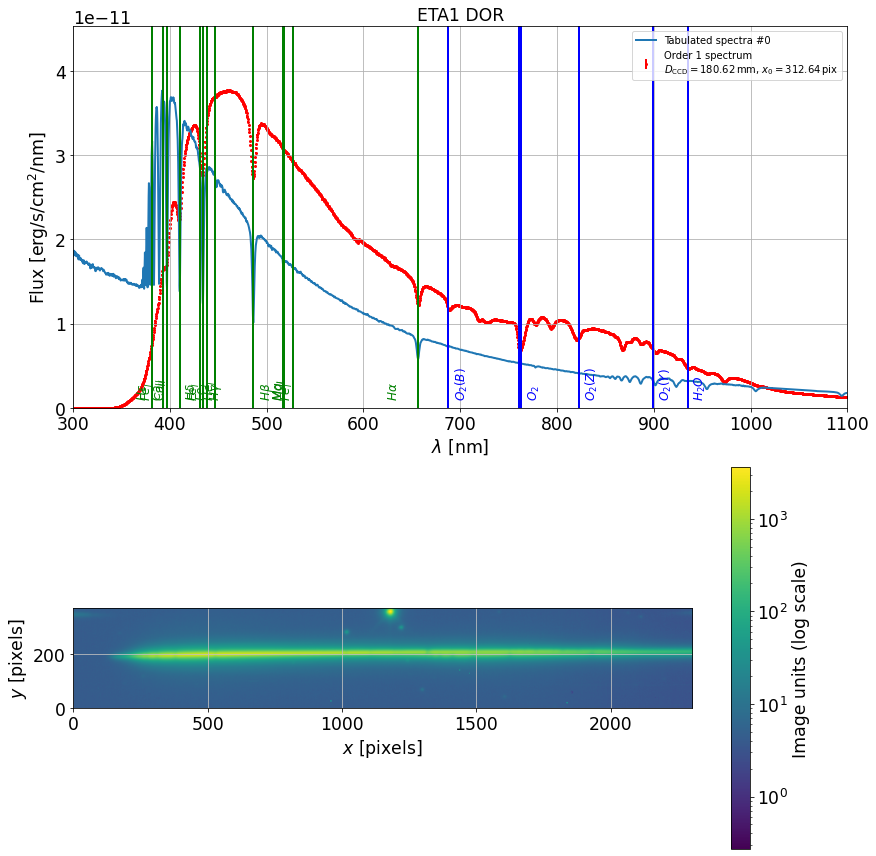

In [56]:
idx=0

fullfilename = all_good_spectra_spectrum_files[idx]
    
filename = os.path.basename(fullfilename)
print(idx,")",filename," ",fullfilename)
    
    
fig=plt.figure(figsize=(12,12))
ax1 = fig.add_subplot(2, 1, 1)
    
filename= os.path.basename(fullfilename)
tag=file_tag_forsorting(filename.split(".")[0])
all_num.append(tag)
    
   
     
s=Spectrum(fullfilename, config=config,fast_load=False)
label=filename.split('.')[0]+" "
#s.plot_spectrum(ax=ax1,force_lines=True,label=label)
s.plot_spectrum(ax=ax1,force_lines=True)
    
    
ax2 = fig.add_subplot(2, 1, 2)
    
fullfilename2=all_files_spectrogram[idx]
    
s.load_spectrogram(fullfilename2)
s.plot_spectrogram(ax=ax2,scale="log")
    

plt.show()
    

In [62]:
# extract a spectrogram in 50 pixels width
spectrogram_cut = np.copy(s.spectrogram[150:250,:])

https://docs.astropy.org/en/stable/_modules/astropy/visualization/stretch.html

In [63]:
# Normalisation
from astropy.visualization import (MinMaxInterval, SqrtStretch,ImageNormalize, SinhStretch,AsinhStretch, LinearStretch)
#from astropy.visualization.stretch import SinhStretch, LinearStretch

# Create an ImageNormalize object
norm = ImageNormalize(spectrogram_cut, interval=MinMaxInterval(),stretch=AsinhStretch())

In [65]:
vmin=s.spectrogram.min()

In [66]:
vmax=s.spectrogram.max()

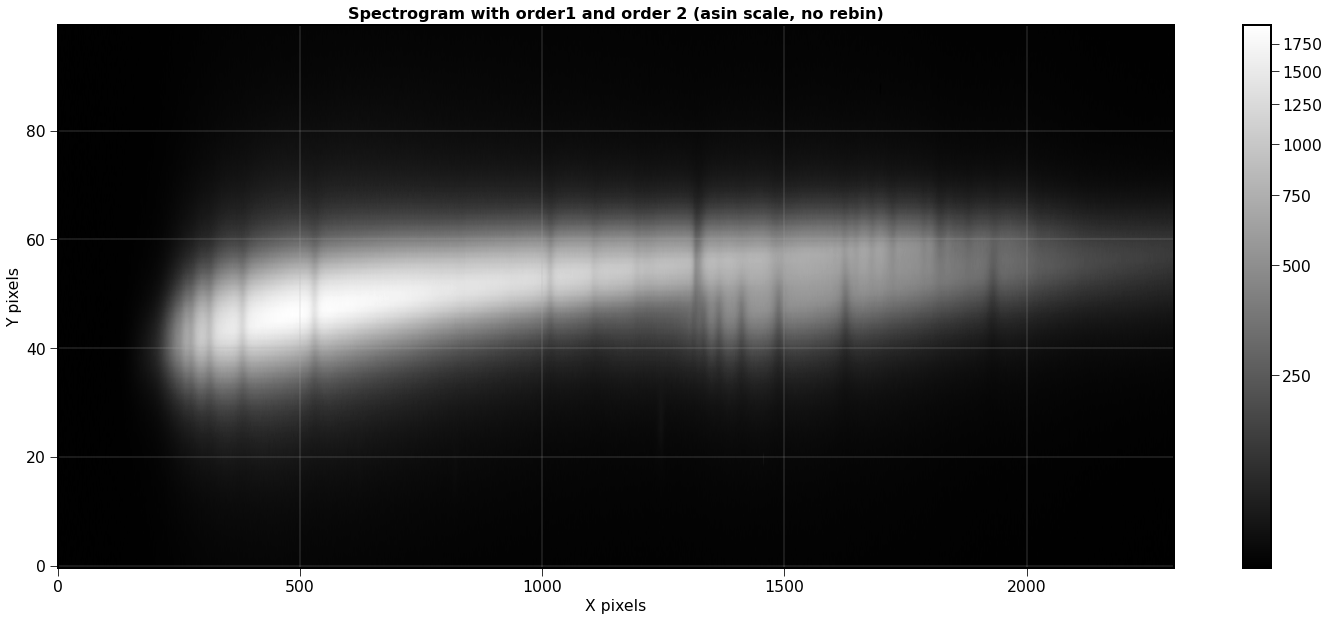

In [169]:
fig = plt.figure(figsize=(25,10))
ax=fig.add_subplot(1,1,1)
#ax.imshow(s.spectrogram,origin="lower",cmap="gray",norm=LogNorm(vmin=0.001*vmin,vmax=1*vmax))
im = ax.imshow(spectrogram_cut,origin="lower",cmap=plt.cm.gray,norm=norm)
ax.set_aspect('auto')
ax.grid()
ax.set_xlabel("X pixels")
ax.set_ylabel("Y pixels")
ax.set_title("Spectrogram with order1 and order 2 (asin scale, no rebin)")
plt.colorbar(im,ax=ax)

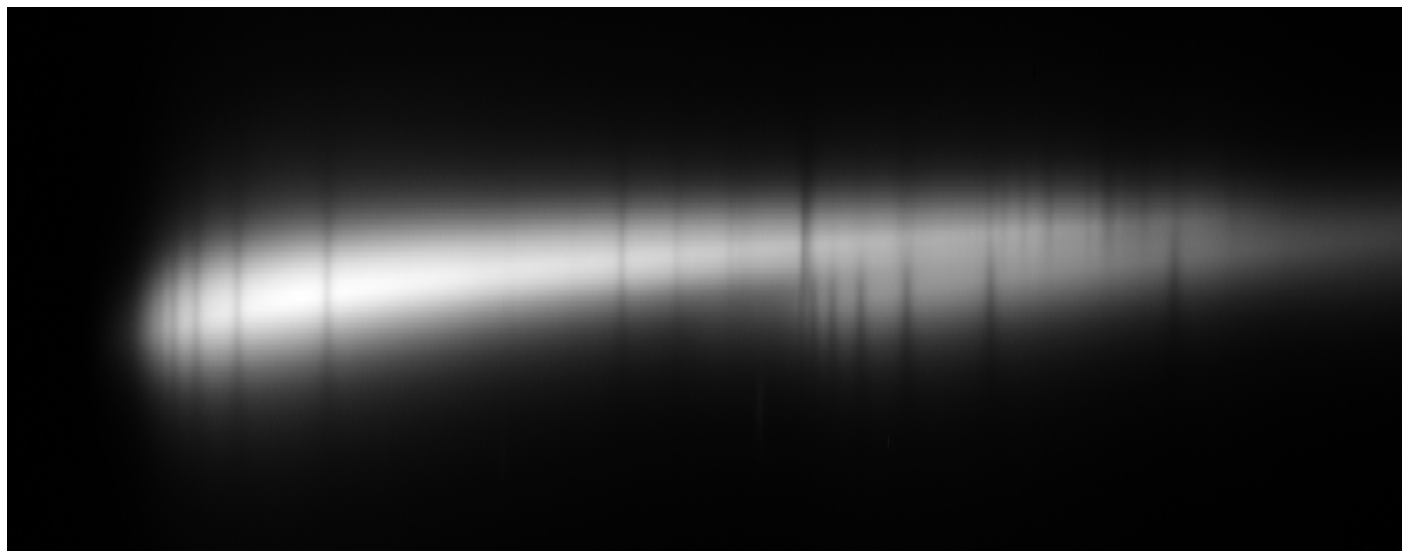

In [207]:
fig = plt.figure(figsize=(25,10))
ax=fig.add_subplot(1,1,1)
#ax.imshow(s.spectrogram,origin="lower",cmap="gray",norm=LogNorm(vmin=0.001*vmin,vmax=1*vmax))
im = ax.imshow(spectrogram_cut,origin="lower",cmap=plt.cm.gray,norm=norm)
ax.set_aspect('auto')
ax.axis('off')
plt.savefig("orderimprints_greys.png")

/tmp/ipykernel_4006/1999466593.py:10: UserWarning: The following kwargs were not used by contour: 'lw'
  ax.contour(spectrogram_cut, levels=np.logspace(1, 4., 20), colors='white',lw=2)


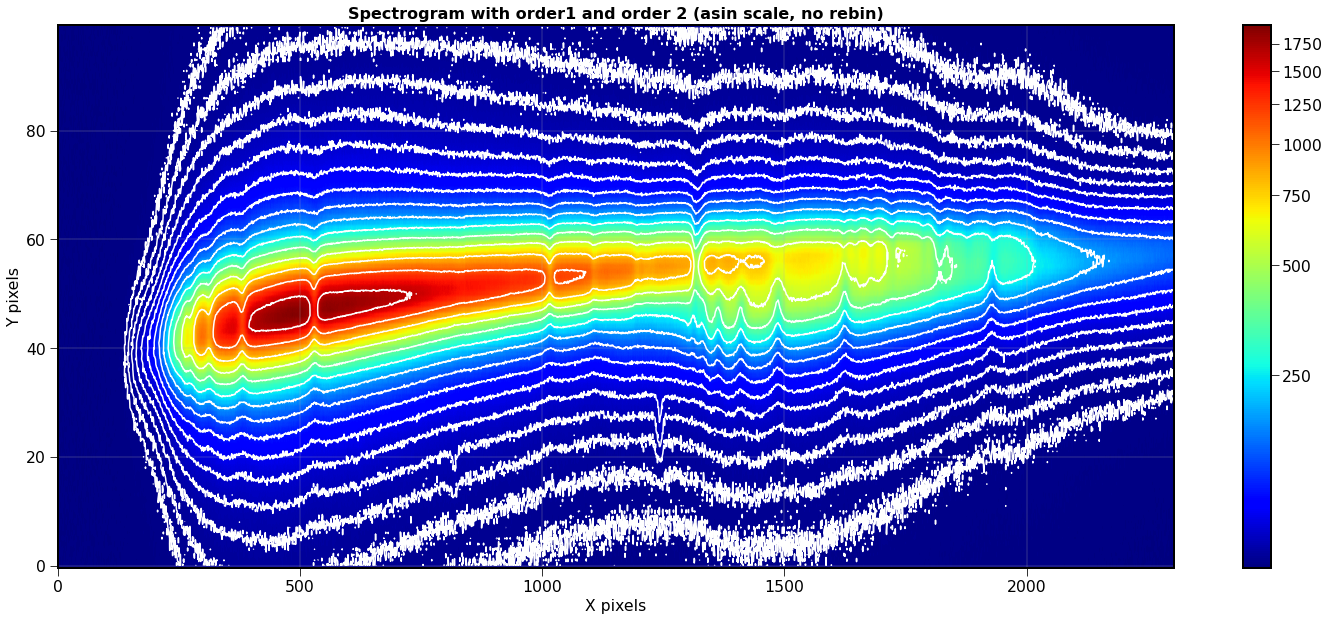

In [244]:
fig = plt.figure(figsize=(25,10))
ax=fig.add_subplot(1,1,1)
#ax.imshow(s.spectrogram,origin="lower",cmap="gray",norm=LogNorm(vmin=0.001*vmin,vmax=1*vmax))
im = ax.imshow(spectrogram_cut,origin="lower",cmap="jet",norm=norm)
ax.set_aspect('auto')
ax.grid()
ax.set_xlabel("X pixels")
ax.set_ylabel("Y pixels")
ax.set_title("Spectrogram with order1 and order 2 (asin scale, no rebin)")
ax.contour(spectrogram_cut, levels=np.logspace(1, 4., 20), colors='white',lw=2)
plt.colorbar(im,ax=ax)

/tmp/ipykernel_4006/2281510023.py:7: UserWarning: The following kwargs were not used by contour: 'lw'
  ax.contour(spectrogram_cut, levels=np.logspace(1, 4., 20), colors='white',lw=2)


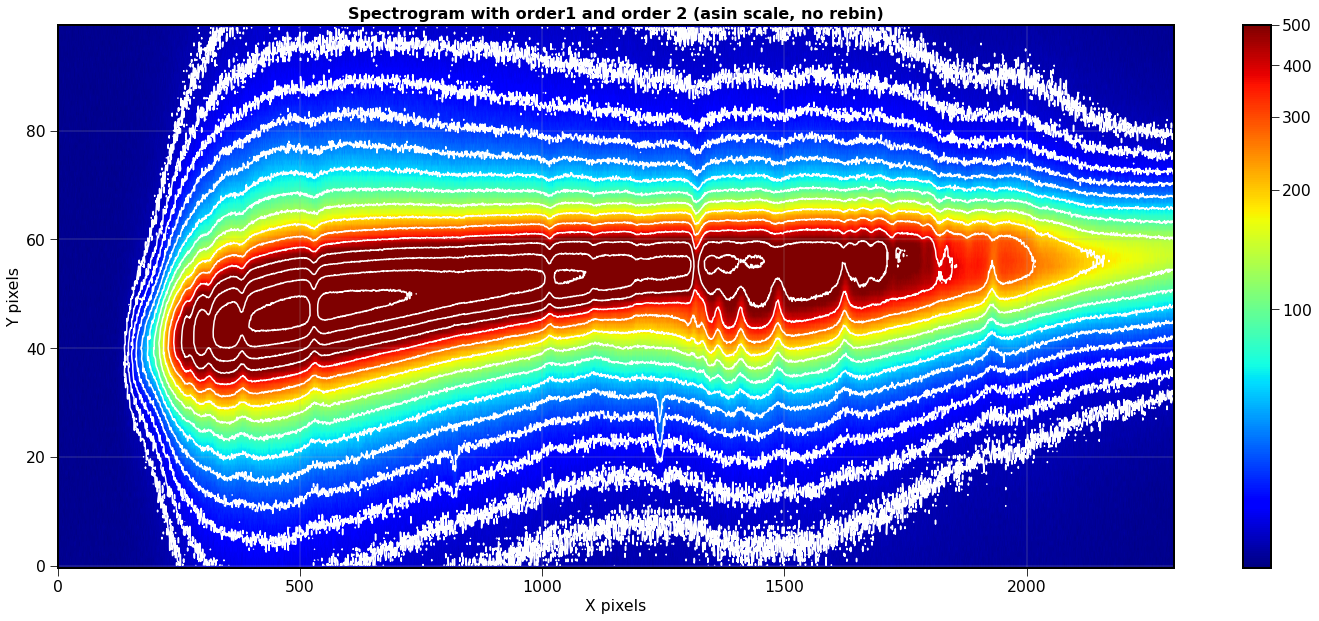

In [245]:
fig = plt.figure(figsize=(25,10))
ax=fig.add_subplot(1,1,1)
#ax.imshow(s.spectrogram,origin="lower",cmap="gray",norm=LogNorm(vmin=0.001*vmin,vmax=1*vmax))
spectrogram_strongcut=np.where(spectrogram_cut>500,500,spectrogram_cut)
norm_strongcut = ImageNormalize(spectrogram_strongcut, interval=MinMaxInterval(),stretch=AsinhStretch())
im = ax.imshow(spectrogram_strongcut ,origin="lower",cmap="jet",norm=norm_strongcut)
ax.contour(spectrogram_cut, levels=np.logspace(1, 4., 20), colors='white',lw=2)
ax.set_aspect('auto')
ax.grid()
ax.set_xlabel("X pixels")
ax.set_ylabel("Y pixels")
ax.set_title("Spectrogram with order1 and order 2 (asin scale, no rebin)")
plt.colorbar(im,ax=ax)

# Study transverse profiles

In [69]:
NY,NX=spectrogram_cut.shape

In [94]:
nx=np.linspace(250,2300,20)

In [82]:
nx

array([ 250.        ,  357.89473684,  465.78947368,  573.68421053,
        681.57894737,  789.47368421,  897.36842105, 1005.26315789,
       1113.15789474, 1221.05263158, 1328.94736842, 1436.84210526,
       1544.73684211, 1652.63157895, 1760.52631579, 1868.42105263,
       1976.31578947, 2084.21052632, 2192.10526316, 2300.        ])

In [87]:
Nslices=len(nx)
# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=Nslices)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(Nslices), alpha=1)

## Profile with an arcsinh transformation

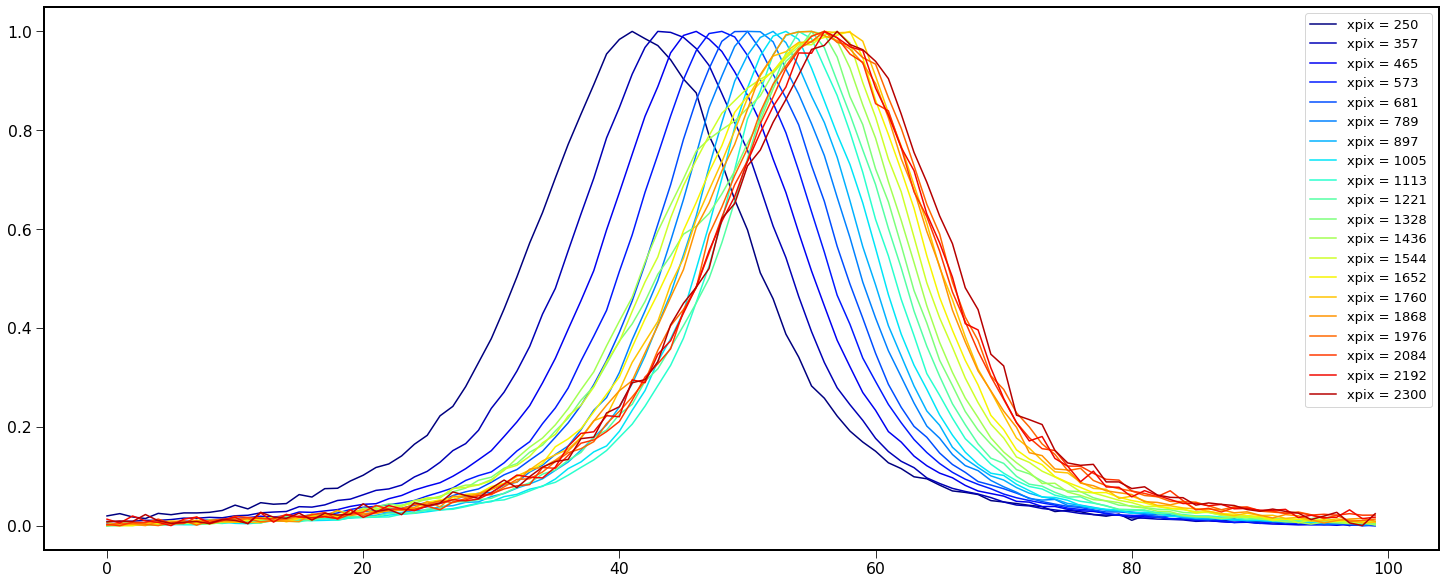

In [160]:
fig = plt.figure(figsize=(25,10))
ax=fig.add_subplot(1,1,1)
idx=0
for islice in nx:
    idx_slice=int(islice)
    the_slice=spectrogram_cut[:,idx_slice]
    the_slice_min = the_slice.min()
    the_slice_max = the_slice.max()
    the_slice_range=the_slice_max - the_slice_min
    the_slice_norm = (the_slice- the_slice_min)/the_slice_range
    a=0.3
    the_slice_values = np.arcsinh(the_slice_norm/a)/np.arcsinh(1/a)
    
    #the_slice_values = norm(the_slice)
    
    label=f"xpix = {idx_slice}"
    ax.plot(np.arange(0,NY),the_slice_values/the_slice_values.max(),color=all_colors[idx],label=label)
    idx+=1
    ax.legend()
    ax.grid()

## Profile with the norm  transformation

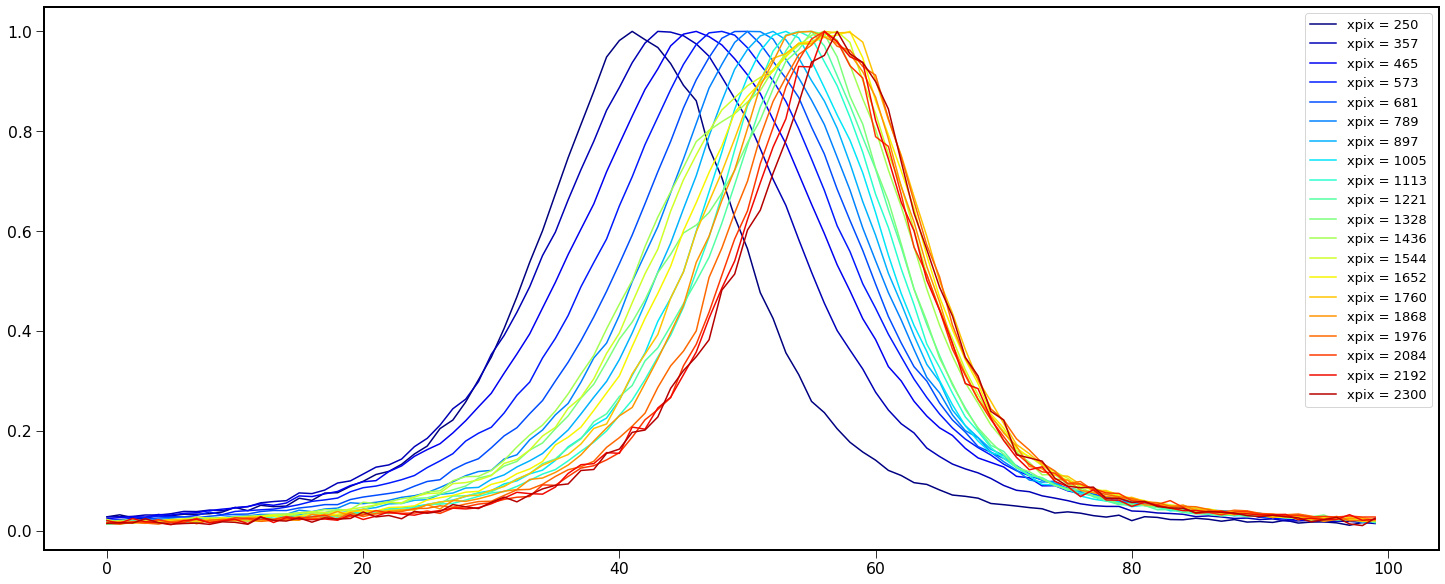

In [143]:
fig = plt.figure(figsize=(25,10))
ax=fig.add_subplot(1,1,1)
idx=0
for islice in nx:
    idx_slice=int(islice)
    the_slice=spectrogram_cut[:,idx_slice]
    the_slice_values = norm(the_slice)
    
    label=f"xpix = {idx_slice}"
    ax.plot(np.arange(0,NY),the_slice_values/the_slice_values.max(),color=all_colors[idx],label=label)
    idx+=1
    ax.legend()
    ax.grid()

## Profile with a log transformation

/tmp/ipykernel_4006/3538755547.py:12: RuntimeWarning: divide by zero encountered in log10
  the_slice_values = np.log10((the_slice_norm/a)/np.arcsinh(1/a))


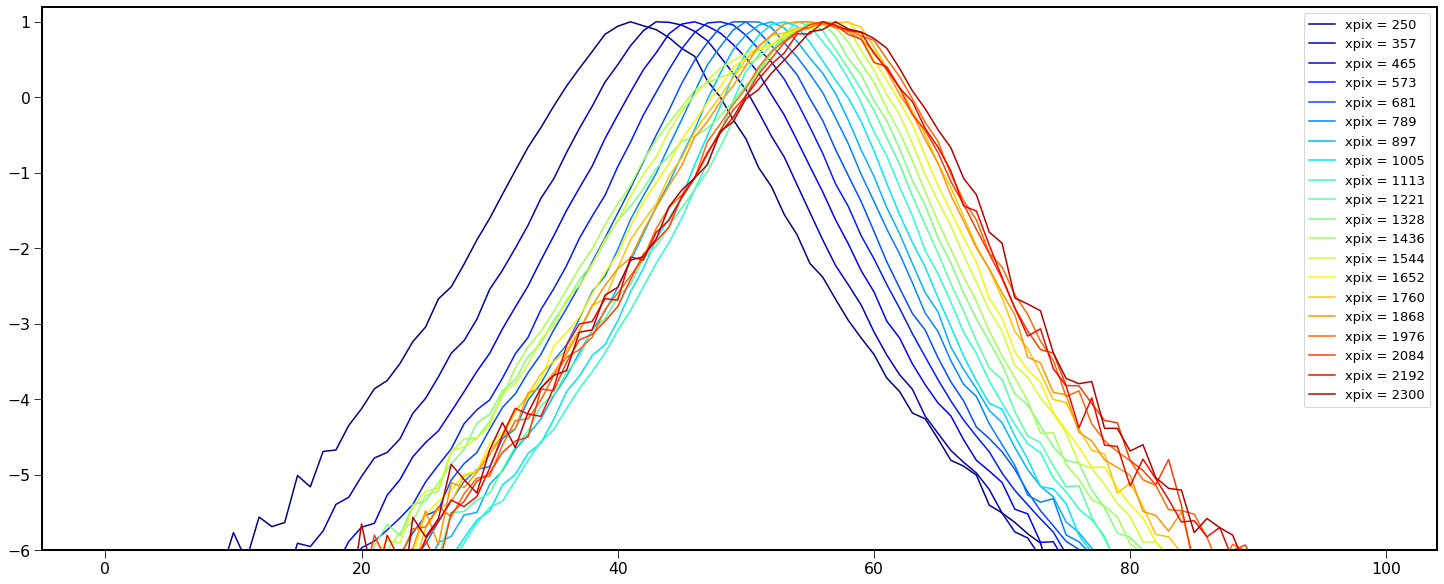

In [161]:
fig = plt.figure(figsize=(25,10))
ax=fig.add_subplot(1,1,1)
idx=0
for islice in nx:
    idx_slice=int(islice)
    the_slice=spectrogram_cut[:,idx_slice]
    the_slice_min = the_slice.min()
    the_slice_max = the_slice.max()
    the_slice_range=the_slice_max - the_slice_min
    the_slice_norm = (the_slice- the_slice_min)/the_slice_range
    a=0.3
    the_slice_values = np.log10((the_slice_norm/a)/np.arcsinh(1/a))
    
    #the_slice_values = norm(the_slice)
    
    label=f"xpix = {idx_slice}"
    ax.plot(np.arange(0,NY),the_slice_values/the_slice_values.max(),color=all_colors[idx],label=label)
    idx+=1
    ax.legend()
    ax.grid()
    ax.set_ylim(-6,1.2)

# Renormalize each column

In [246]:
spectrogram_renorm = np.copy(spectrogram_cut)

In [249]:
spectrogram_renorm  = spectrogram_renorm /spectrogram_cut.max(axis=0)

In [250]:
norm_renorm = ImageNormalize(spectrogram_renorm, interval=MinMaxInterval(),stretch=AsinhStretch())

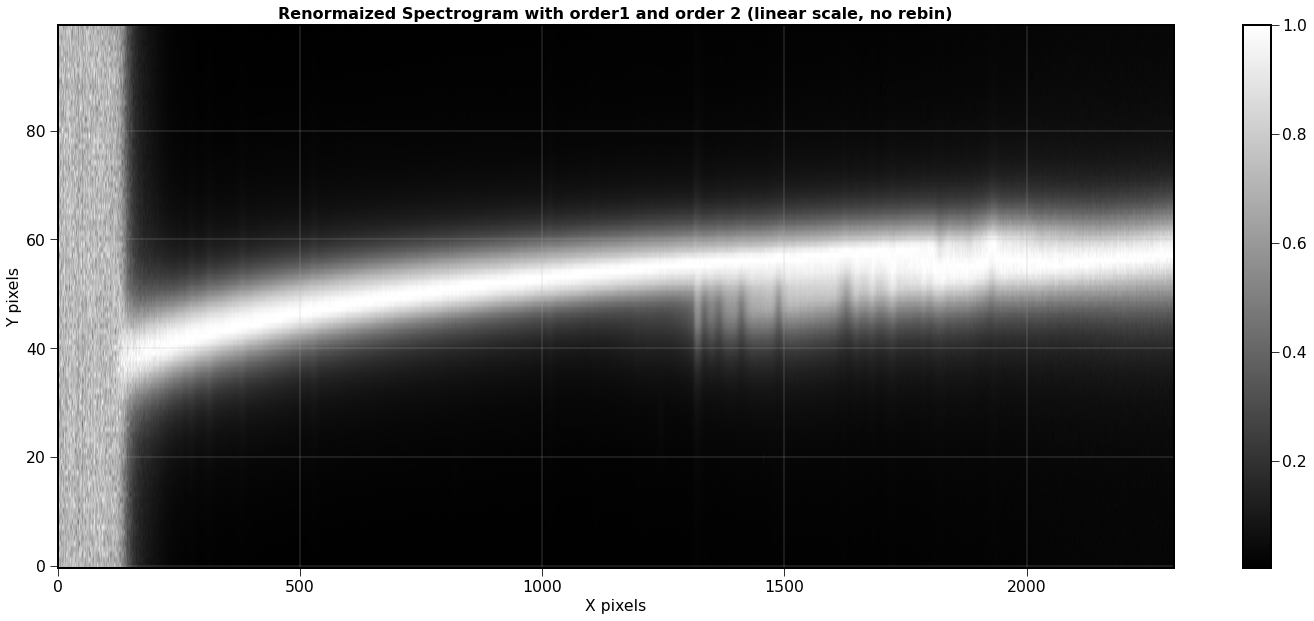

In [253]:
fig = plt.figure(figsize=(25,10))
ax=fig.add_subplot(1,1,1)
#ax.imshow(s.spectrogram,origin="lower",cmap="gray",norm=LogNorm(vmin=0.001*vmin,vmax=1*vmax))
im = ax.imshow(spectrogram_renorm,origin="lower",cmap=plt.cm.gray)
ax.set_aspect('auto')
ax.grid()
ax.set_xlabel("X pixels")
ax.set_ylabel("Y pixels")
ax.set_title("Renormaized Spectrogram with order1 and order 2 (linear scale, no rebin)")
plt.colorbar(im,ax=ax)

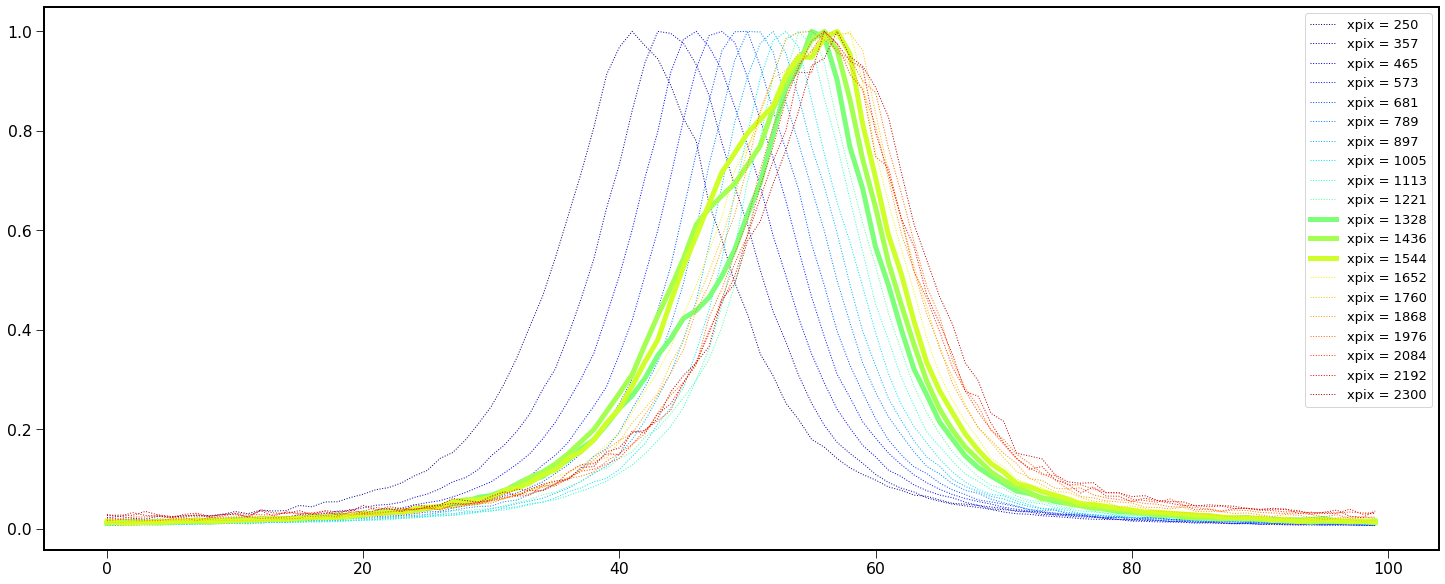

In [269]:
fig = plt.figure(figsize=(25,10))
ax=fig.add_subplot(1,1,1)
idx=0
for islice in nx:
    idx_slice=int(islice)
    the_slice=spectrogram_renorm[:,idx_slice]
     
    
    label=f"xpix = {idx_slice}"
    
    if idx_slice > 1300 and idx_slice < 1600 :
        ax.plot(np.arange(0,NY),the_slice,color=all_colors[idx],label=label,lw=5)
    else:
        ax.plot(np.arange(0,NY),the_slice,":",color=all_colors[idx],label=label,lw=1)
        pass
    idx+=1
    ax.legend()
    ax.grid()